<a href="https://colab.research.google.com/github/aimee-annabelle/Intro_to_ML_Summative/blob/main/Summative_Intro_to_ml_Annabelle_Ineza_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Optimization Techniques in Machine Learning

Objective: This assignment aims to explore implementation or Machine Learning Models with regularization, optimization and Error analysis  techniques used in machine learning to improve models' performance, convergence speed, and efficiency..

A Notebook detailing the following

* Project name: Drug Demand Classification System for Health Clinics
* Clear out puts from cells




**Instructions**

1. Acquire a dataset suitable for ML tasks as per your proposal.
2. Implement a simple machine learning model based on neural networks on the chosen dataset without any defined optimization techniques. (Check instructions)
3. Implement and compare the model's performance after applying 3 to 4 disntict combinations regularization and optimization techniques.
4. Discuss the results on the README file.
5. Make predictions using test data
7. Implement error analysis techniques and ensure there is: F1-Score, Recall, Precision, RUC a confusion matrix using plotting libraries (not verbose)

Submit notebook to github repo




# Case Study and Implementation




In [ ]:
import sys
!{sys.executable} -m pip install xgboost

In [3]:
#Import Necessary Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, accuracy_score
import xgboost as xgb
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.regularizers import l1, l2, l1_l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
import warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully!")

Libraries imported successfully!


# The Dataset
> ***Brief Description:***
State the Problem and A short Description of the data


In [7]:
#TO DO: Load Data (Seprate into: Train, Validation and test sets)


def load_and_preprocess_data(file_path):
    """
    Load drug consumption data and create classification labels
    """
    # Load data
    df = pd.read_csv(file_path)
    
    # Convert date column
    df['datum'] = pd.to_datetime(df['datum'], format='%m/%d/%Y')
    
    # Extract date features
    df['year'] = df['datum'].dt.year
    df['month'] = df['datum'].dt.month
    df['day_of_year'] = df['datum'].dt.dayofyear
    df['quarter'] = df['datum'].dt.quarter
    
    # Create lag features for time series context
    drug_columns = [col for col in df.columns if col not in ['datum', 'year', 'month', 'day_of_year', 'quarter']]
    
    for col in drug_columns:
        df[f'{col}_lag1'] = df[col].shift(1)
        df[f'{col}_lag7'] = df[col].shift(7)  # Weekly lag
        df[f'{col}_rolling_mean'] = df[col].rolling(window=7).mean()
    
    # Drop rows with NaN values
    df = df.dropna()
    
    # Create target variable: classify total demand into categories
    df['total_demand'] = df[drug_columns].sum(axis=1)
    
    # Create demand categories based on percentiles
    low_threshold = df['total_demand'].quantile(0.33)
    high_threshold = df['total_demand'].quantile(0.67)
    
    def categorize_demand(demand):
        if demand <= low_threshold:
            return 0  # Low demand
        elif demand <= high_threshold:
            return 1  # Medium demand
        else:
            return 2  # High demand
    
    df['demand_category'] = df['total_demand'].apply(categorize_demand)
    
    print(f"Data shape: {df.shape}")
    print(f"Demand distribution:\n{df['demand_category'].value_counts().sort_index()}")
    
    return df
df = load_and_preprocess_data('salesweekly.csv')

Data shape: (295, 39)
Demand distribution:
demand_category
0    98
1    99
2    98
Name: count, dtype: int64


In [8]:
# Data splitting
# Prepare features and target
feature_columns = [col for col in df.columns if col not in ['datum', 'total_demand', 'demand_category']]
X = df[feature_columns]
y = df['demand_category']

# Split data
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print(f"Training set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")
print(f"Test set: {X_test.shape}")

Training set: (177, 36)
Validation set: (59, 36)
Test set: (59, 36)


#SECTION 1: Model Architecture:



```
TODO: Insert an image with the Model architecture here.Replace the image Below
```
> <img src="https://miro.medium.com/v2/resize:fit:640/format:webp/1*v1ohAG82xmU6WGsG2hoE8g.png" alt="?" style="width:25px"/>




#Task: Define a function that creates models without and With specified Optimization techniques


In [9]:
# ==================== MODEL 1: CLASSICAL ML (LOGISTIC REGRESSION) ====================

print("\n" + "="*50)
print("MODEL 1: LOGISTIC REGRESSION (OPTIMIZED)")
print("="*50)

# Hyperparameter tuning for Logistic Regression
lr_params = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'lbfgs'],
    'max_iter': [1000, 2000]
}

lr_grid = GridSearchCV(LogisticRegression(random_state=42), lr_params, cv=5, scoring='f1_macro')
lr_grid.fit(X_train_scaled, y_train)

lr_model = lr_grid.best_estimator_
lr_pred = lr_model.predict(X_test_scaled)

print(f"Best parameters: {lr_grid.best_params_}")
print(f"Accuracy: {accuracy_score(y_test, lr_pred):.4f}")
print(f"F1-Score: {f1_score(y_test, lr_pred, average='macro'):.4f}")
print(f"Precision: {precision_score(y_test, lr_pred, average='macro'):.4f}")
print(f"Recall: {recall_score(y_test, lr_pred, average='macro'):.4f}")




MODEL 1: LOGISTIC REGRESSION (OPTIMIZED)
Best parameters: {'C': 10, 'max_iter': 1000, 'solver': 'lbfgs'}
Accuracy: 0.8644
F1-Score: 0.8672
Precision: 0.8727
Recall: 0.8649


In [11]:
# ==================== MODEL 2: SIMPLE NEURAL NETWORK (NO OPTIMIZATION) ====================

print("\n" + "="*50)
print("MODEL 2: SIMPLE NEURAL NETWORK (NO OPTIMIZATION)")
print("="*50)

def create_simple_model(input_dim, num_classes):
    model = Sequential([
        Dense(64, activation='relu', input_dim=input_dim),
        Dense(32, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

simple_nn = create_simple_model(X_train_scaled.shape[1], 3)
history_simple = simple_nn.fit(X_train_scaled, y_train, 
                               validation_data=(X_val_scaled, y_val),
                               epochs=50, batch_size=32, verbose=0)

simple_pred = simple_nn.predict(X_test_scaled)
simple_pred_classes = np.argmax(simple_pred, axis=1)

print(f"Accuracy: {accuracy_score(y_test, simple_pred_classes):.4f}")
print(f"F1-Score: {f1_score(y_test, simple_pred_classes, average='macro'):.4f}")
print(f"Precision: {precision_score(y_test, simple_pred_classes, average='macro'):.4f}")
print(f"Recall: {recall_score(y_test, simple_pred_classes, average='macro'):.4f}")


MODEL 2: SIMPLE NEURAL NETWORK (NO OPTIMIZATION)
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 287ms/step
Accuracy: 0.7627
F1-Score: 0.7684
Precision: 0.7861
Recall: 0.7623


In [13]:
# ==================== MODEL 3: OPTIMIZED NEURAL NETWORK ====================

print("\n" + "="*50)
print("MODEL 3: OPTIMIZED NEURAL NETWORK")
print("="*50)

def create_optimized_model(input_dim, num_classes, optimizer='adam', learning_rate=0.001, 
                          dropout_rate=0.3, l2_reg=0.001):
    model = Sequential([
        Dense(128, activation='relu', input_dim=input_dim, 
              kernel_regularizer=l2(l2_reg)),
        Dropout(dropout_rate),
        Dense(64, activation='relu', kernel_regularizer=l2(l2_reg)),
        Dropout(dropout_rate),
        Dense(32, activation='relu', kernel_regularizer=l2(l2_reg)),
        Dense(num_classes, activation='softmax')
    ])
    
    if optimizer == 'adam':
        opt = Adam(learning_rate=learning_rate)
    elif optimizer == 'rmsprop':
        opt = RMSprop(learning_rate=learning_rate)
    else:
        opt = SGD(learning_rate=learning_rate)
    
    model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Training multiple instances with different configurations
results_table = []


MODEL 3: OPTIMIZED NEURAL NETWORK


In [14]:
# Instance 1: Default settings
print("\nInstance 1: Default Configuration")
model1 = create_optimized_model(X_train_scaled.shape[1], 3)
history1 = model1.fit(X_train_scaled, y_train, 
                     validation_data=(X_val_scaled, y_val),
                     epochs=50, batch_size=32, verbose=0)

pred1 = model1.predict(X_test_scaled)
pred1_classes = np.argmax(pred1, axis=1)

results_table.append({
    'Instance': 1,
    'Optimizer': 'Adam (default)',
    'Learning_Rate': 0.001,
    'Dropout': 0.3,
    'L2_Regularization': 0.001,
    'Early_Stopping': 'No',
    'Epochs': 50,
    'Accuracy': accuracy_score(y_test, pred1_classes),
    'Loss': history1.history['val_loss'][-1],
    'F1_Score': f1_score(y_test, pred1_classes, average='macro'),
    'Precision': precision_score(y_test, pred1_classes, average='macro'),
    'Recall': recall_score(y_test, pred1_classes, average='macro')
})


Instance 1: Default Configuration
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step   


In [15]:
# Instance 2: Adam with Early Stopping
print("\nInstance 2: Adam + Early Stopping")
model2 = create_optimized_model(X_train_scaled.shape[1], 3, optimizer='adam', 
                               learning_rate=0.01, dropout_rate=0.4, l2_reg=0.01)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history2 = model2.fit(X_train_scaled, y_train, 
                     validation_data=(X_val_scaled, y_val),
                     epochs=100, batch_size=32, callbacks=[early_stopping], verbose=0)

pred2 = model2.predict(X_test_scaled)
pred2_classes = np.argmax(pred2, axis=1)

results_table.append({
    'Instance': 2,
    'Optimizer': 'Adam',
    'Learning_Rate': 0.01,
    'Dropout': 0.4,
    'L2_Regularization': 0.01,
    'Early_Stopping': 'Yes',
    'Epochs': len(history2.history['loss']),
    'Accuracy': accuracy_score(y_test, pred2_classes),
    'Loss': history2.history['val_loss'][-1],
    'F1_Score': f1_score(y_test, pred2_classes, average='macro'),
    'Precision': precision_score(y_test, pred2_classes, average='macro'),
    'Recall': recall_score(y_test, pred2_classes, average='macro')
})


Instance 2: Adam + Early Stopping
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 544ms/stepWARNING:tensorflow:6 out of the last 6 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x000001BBF5485EE0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 500ms/step


In [16]:
# Instance 3: RMSprop with different settings
print("\nInstance 3: RMSprop + High Dropout")
model3 = create_optimized_model(X_train_scaled.shape[1], 3, optimizer='rmsprop', 
                               learning_rate=0.005, dropout_rate=0.5, l2_reg=0.005)
history3 = model3.fit(X_train_scaled, y_train, 
                     validation_data=(X_val_scaled, y_val),
                     epochs=75, batch_size=16, verbose=0)

pred3 = model3.predict(X_test_scaled)
pred3_classes = np.argmax(pred3, axis=1)

results_table.append({
    'Instance': 3,
    'Optimizer': 'RMSprop',
    'Learning_Rate': 0.005,
    'Dropout': 0.5,
    'L2_Regularization': 0.005,
    'Early_Stopping': 'No',
    'Epochs': 75,
    'Accuracy': accuracy_score(y_test, pred3_classes),
    'Loss': history3.history['val_loss'][-1],
    'F1_Score': f1_score(y_test, pred3_classes, average='macro'),
    'Precision': precision_score(y_test, pred3_classes, average='macro'),
    'Recall': recall_score(y_test, pred3_classes, average='macro')
})


Instance 3: RMSprop + High Dropout
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 885ms/step


In [17]:
# Instance 4: SGD with momentum
print("\nInstance 4: SGD + Lower Learning Rate")
model4 = create_optimized_model(X_train_scaled.shape[1], 3, optimizer='sgd', 
                               learning_rate=0.01, dropout_rate=0.2, l2_reg=0.01)
early_stopping2 = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
history4 = model4.fit(X_train_scaled, y_train, 
                     validation_data=(X_val_scaled, y_val),
                     epochs=100, batch_size=64, callbacks=[early_stopping2], verbose=0)

pred4 = model4.predict(X_test_scaled)
pred4_classes = np.argmax(pred4, axis=1)

results_table.append({
    'Instance': 4,
    'Optimizer': 'SGD',
    'Learning_Rate': 0.01,
    'Dropout': 0.2,
    'L2_Regularization': 0.01,
    'Early_Stopping': 'Yes',
    'Epochs': len(history4.history['loss']),
    'Accuracy': accuracy_score(y_test, pred4_classes),
    'Loss': history4.history['val_loss'][-1],
    'F1_Score': f1_score(y_test, pred4_classes, average='macro'),
    'Precision': precision_score(y_test, pred4_classes, average='macro'),
    'Recall': recall_score(y_test, pred4_classes, average='macro')
})



Instance 4: SGD + Lower Learning Rate
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 496ms/step


In [18]:
# Instance 5: High learning rate with strong regularization
print("\nInstance 5: High LR + Strong Regularization")
model5 = create_optimized_model(X_train_scaled.shape[1], 3, optimizer='adam', 
                               learning_rate=0.1, dropout_rate=0.6, l2_reg=0.1)
history5 = model5.fit(X_train_scaled, y_train, 
                     validation_data=(X_val_scaled, y_val),
                     epochs=50, batch_size=32, verbose=0)

pred5 = model5.predict(X_test_scaled)
pred5_classes = np.argmax(pred5, axis=1)

results_table.append({
    'Instance': 5,
    'Optimizer': 'Adam',
    'Learning_Rate': 0.1,
    'Dropout': 0.6,
    'L2_Regularization': 0.1,
    'Early_Stopping': 'No',
    'Epochs': 50,
    'Accuracy': accuracy_score(y_test, pred5_classes),
    'Loss': history5.history['val_loss'][-1],
    'F1_Score': f1_score(y_test, pred5_classes, average='macro'),
    'Precision': precision_score(y_test, pred5_classes, average='macro'),
    'Recall': recall_score(y_test, pred5_classes, average='macro')
})



Instance 5: High LR + Strong Regularization
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 589ms/step


In [19]:
# Results table
results_df = pd.DataFrame(results_table)
print("\n" + "="*100)
print("NEURAL NETWORK OPTIMIZATION RESULTS TABLE")
print("="*100)
print(results_df.round(4))


NEURAL NETWORK OPTIMIZATION RESULTS TABLE
   Instance       Optimizer  Learning_Rate  Dropout  L2_Regularization  \
0         1  Adam (default)          0.001      0.3              0.001   
1         2            Adam          0.010      0.4              0.010   
2         3         RMSprop          0.005      0.5              0.005   
3         4             SGD          0.010      0.2              0.010   
4         5            Adam          0.100      0.6              0.100   

  Early_Stopping  Epochs  Accuracy    Loss  F1_Score  Precision  Recall  
0             No      50    0.8305  0.6191    0.8259     0.8295  0.8316  
1            Yes      22    0.8814  0.6966    0.8820     0.8822  0.8825  
2             No      75    0.7797  0.7090    0.7606     0.7895  0.7816  
3            Yes     100    0.7627  2.3263    0.7516     0.7703  0.7632  
4             No      50    0.3390  1.1122    0.1688     0.1130  0.3333  


In [20]:
# ==================== MODEL 4: XGBOOST ====================

print("\n" + "="*50)
print("MODEL 4: XGBOOST (OPTIMIZED)")
print("="*50)

xgb_params = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0]
}

xgb_grid = GridSearchCV(xgb.XGBClassifier(random_state=42), 
                        xgb_params, cv=3, scoring='f1_macro', n_jobs=-1)
xgb_grid.fit(X_train_scaled, y_train)

xgb_model = xgb_grid.best_estimator_
xgb_pred = xgb_model.predict(X_test_scaled)

print(f"Best parameters: {xgb_grid.best_params_}")
print(f"Accuracy: {accuracy_score(y_test, xgb_pred):.4f}")
print(f"F1-Score: {f1_score(y_test, xgb_pred, average='macro'):.4f}")
print(f"Precision: {precision_score(y_test, xgb_pred, average='macro'):.4f}")
print(f"Recall: {recall_score(y_test, xgb_pred, average='macro'):.4f}")



MODEL 4: XGBOOST (OPTIMIZED)
Best parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
Accuracy: 0.8644
F1-Score: 0.8638
Precision: 0.8778
Recall: 0.8632


# Task: Print out the Final Model Accuracy and plot the Loss curve

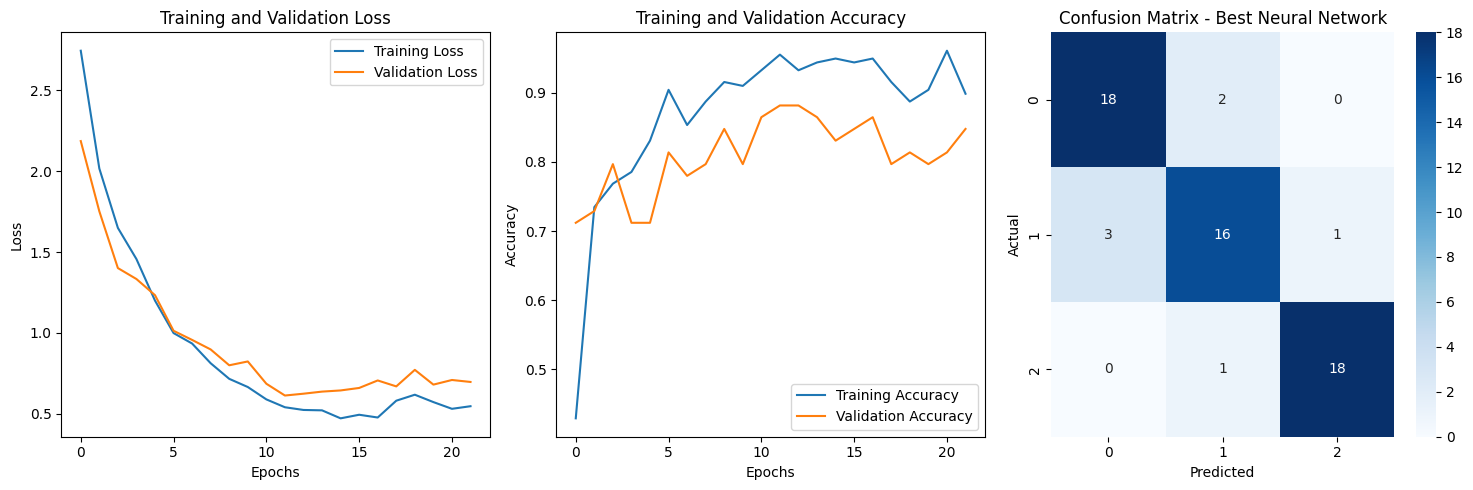

In [21]:
# Plot training history for the best neural network model
best_idx = results_df['F1_Score'].idxmax()
best_model_history = [history1, history2, history3, history4, history5][best_idx]

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(best_model_history.history['loss'], label='Training Loss')
plt.plot(best_model_history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(best_model_history.history['accuracy'], label='Training Accuracy')
plt.plot(best_model_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Confusion Matrix for best model
best_pred = [pred1_classes, pred2_classes, pred3_classes, pred4_classes, pred5_classes][best_idx]
plt.subplot(1, 3, 3)
cm = confusion_matrix(y_test, best_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Best Neural Network')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.tight_layout()
plt.show()

# SECTION 2: Optimization and Regularization Combinations
At this point you should now create models that combine various optimization techniques
As done before make sure to plot out the loss curve and the accuracy and loss in verbose

#Task: Make Predictions using the best saved model


Create a confusion Matrix and F1 score for both Models. Ensure outputs for the cells are visible

Finally, Make predictions using the best model. By the time you get to this cell you may realise at some point you needed to save the model so that you cal load it later

In [23]:

# ==================== MODEL COMPARISON ====================

print("\n" + "="*70)
print("FINAL MODEL COMPARISON")
print("="*70)

models_comparison = {
    'Model': ['Logistic Regression', 'Simple Neural Network', 'Best Neural Network', 'XGBoost'],
    'Accuracy': [
        accuracy_score(y_test, lr_pred),
        accuracy_score(y_test, simple_pred_classes),
        accuracy_score(y_test, best_pred),
        accuracy_score(y_test, xgb_pred)
    ],
    'F1_Score': [
        f1_score(y_test, lr_pred, average='macro'),
        f1_score(y_test, simple_pred_classes, average='macro'),
        f1_score(y_test, best_pred, average='macro'),
        f1_score(y_test, xgb_pred, average='macro')
    ],
    'Precision': [
        precision_score(y_test, lr_pred, average='macro'),
        precision_score(y_test, simple_pred_classes, average='macro'),
        precision_score(y_test, best_pred, average='macro'),
        precision_score(y_test, xgb_pred, average='macro')
    ],
    'Recall': [
        recall_score(y_test, lr_pred, average='macro'),
        recall_score(y_test, simple_pred_classes, average='macro'),
        recall_score(y_test, best_pred, average='macro'),
        recall_score(y_test, xgb_pred, average='macro')
    ]
}

comparison_df = pd.DataFrame(models_comparison)
print(comparison_df.round(4))



FINAL MODEL COMPARISON
                   Model  Accuracy  F1_Score  Precision  Recall
0    Logistic Regression    0.8644    0.8672     0.8727  0.8649
1  Simple Neural Network    0.7627    0.7684     0.7861  0.7623
2    Best Neural Network    0.8814    0.8820     0.8822  0.8825
3                XGBoost    0.8644    0.8638     0.8778  0.8632


In [27]:
# Save the best model
best_model = [model1, model2, model3, model4, model5][best_idx]
best_model.save('saved_models/best_drug_demand_model.keras')
print(f"\nBest model saved as 'best_drug_demand_model.keras'")
print(f"Best model configuration: Instance {best_idx + 1}")


Best model saved as 'best_drug_demand_model.keras'
Best model configuration: Instance 2


In [28]:
def make_predictions(model_path, X_new):
    """
    Load saved model and make predictions on new data
    """
    model = load_model(model_path)
    predictions = model.predict(X_new)
    predicted_classes = np.argmax(predictions, axis=1)
    
    # Convert to demand categories
    demand_labels = {0: 'Low Demand', 1: 'Medium Demand', 2: 'High Demand'}
    predicted_labels = [demand_labels[pred] for pred in predicted_classes]
    
    return predicted_classes, predicted_labels, predictions

# Example prediction
sample_predictions, sample_labels, sample_probs = make_predictions('saved_models/best_drug_demand_model.keras', X_test_scaled[:10])
print("\n" + "="*50)
print("SAMPLE PREDICTIONS")
print("="*50)
for i, (pred_class, pred_label, probs) in enumerate(zip(sample_predictions, sample_labels, sample_probs)):
    print(f"Sample {i+1}: {pred_label} (Class {pred_class}) - Confidence: {max(probs):.3f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 536ms/step

SAMPLE PREDICTIONS
Sample 1: Low Demand (Class 0) - Confidence: 0.969
Sample 2: High Demand (Class 2) - Confidence: 0.985
Sample 3: Low Demand (Class 0) - Confidence: 0.993
Sample 4: Low Demand (Class 0) - Confidence: 0.996
Sample 5: Low Demand (Class 0) - Confidence: 0.985
Sample 6: High Demand (Class 2) - Confidence: 0.999
Sample 7: High Demand (Class 2) - Confidence: 0.969
Sample 8: High Demand (Class 2) - Confidence: 0.999
Sample 9: High Demand (Class 2) - Confidence: 0.503
Sample 10: High Demand (Class 2) - Confidence: 0.763


Congratulations!!
